In [300]:
import pathlib
from typing import Dict, Optional, Tuple

import lifelines
import lightning as L
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import chi2
from scipy.stats import norm
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
DATA_DIR = pathlib.Path("~/Data/CPH200B")

project_1_data_dir = DATA_DIR / "Project 1"
project_2_data_dir = DATA_DIR / "Project 2"

## 2.1 Warm-up Exercise: Hypothesis Testing & Confounding [6 pts]

The most basic form of causal inference involves comparing survival curves in different groups stratified by an
intervention of interest. In this task, we will implement hypothesis testing methods to examine whether differences between the outcomes of treated and untreated patients are statistically significant, and whether these
difference reflect the causal effect of the intervention.

For all the tasks below, we will use the UNOS heart transplant [1] dataset from Project 1.

In [25]:
patient_variables = [
    "init_age",
    "gender",
    "hgt_cm_tcr",
    "wgt_kg_tcr",
    "diab",
    "ventilator_tcr",
    "ecmo_tcr",
    "most_rcnt_creat",
    "abo_A",
    "abo_B",
    "abo_O",
    "vad_while_listed",
    "iabp_tcr",
    "tah",
    "inotropic",
    "Censor (Censor = 1)",
    "Survival Time",
]

# Load the data
unos_filepath = project_1_data_dir / "UNOS_train.csv"
unos = pd.read_csv(unos_filepath, index_col=0)

# Select relevant columns and create event column
unos = unos[patient_variables]
unos["event"] = unos["Censor (Censor = 1)"] == 0
unos = unos.drop(columns=["Censor (Censor = 1)"])

# Filter non-negative survival times and reset index
is_valid = unos["Survival Time"] >= 0
unos = unos[is_valid]
unos = unos.reset_index(drop=True)

### Task 2.1.1 [1 pts]. 
Implement the Log-Rank test from scratch in Python. Using the UNOS dataset, apply
your implemented test to check whether the survival outcomes of patients on ventricular assist device (VAD)
support differ from those of patients without VAD support.

In [ ]:
def adjusted_logrank_test(
    time_a: np.ndarray,
    time_b: np.ndarray,
    event_a: np.ndarray,
    event_b: np.ndarray,
    weights_a: Optional[np.ndarray] = None,
    weights_b: Optional[np.ndarray] = None,
) -> Tuple[float, float]:
    """Adjusted logrank test for two groups.

    Args:
        time_a (np.ndarray): Times for group A.
        time_b (np.ndarray): Times for group B.
        event_a (np.ndarray): Event indicators for group A.
        event_b (np.ndarray): Event indicators for group B.
        weights_a (np.ndarray, optional): Weights (propensity scores)
            for group A.
        weights_b (np.ndarray, optional): Weights (propensity scores)
            for group B.

    Returns:
        Tuple[float, float]: Test statistic and p-value.

    References:
        J. Xie and C. Liu, “Adjusted Kaplan–Meier estimator and log‐rank
        test with inverse probability of treatment weighting for
        survival data,” Statistics in Medicine, vol. 24, no. 20, pp.
        3089–3110, Oct. 2005, doi: 10.1002/sim.2174.
    """
    # Default weights are all ones (standard logrank test)
    if weights_a is None:
        weights_a = np.ones_like(time_a)
    if weights_b is None:
        weights_b = np.ones_like(time_b)

    # Combine data
    times = np.concatenate((time_a, time_b))
    events = np.concatenate((event_a, event_b))
    groups = np.concatenate(
        (np.zeros(len(time_a)), np.ones(len(time_b)))
    )  # 0=A, 1=B
    weights = np.concatenate((weights_a, weights_b))

    # Unique event times where at least one event occurred
    event_times = np.unique(times[events == 1])
    event_times.sort()

    G_w = 0.0  # Weighted test statistic
    Var_w = 0.0  # Variance

    for t in event_times:
        # Unweighted quantities
        at_risk = times >= t
        Y_j = np.sum(at_risk)  # Total at risk (unweighted)
        at_time_t = (times == t) & (events == 1)
        d_j = np.sum(at_time_t)  # Total events (unweighted)

        if Y_j == 0:
            continue

        # Weighted quantities
        Y_j0_w = np.sum(weights[at_risk & (groups == 0)])  # Group A at risk
        Y_j1_w = np.sum(weights[at_risk & (groups == 1)])  # Group B at risk
        Y_j_w = Y_j0_w + Y_j1_w
        d_j1_w = np.sum(weights[at_time_t & (groups == 1)])  # Group B events
        d_j_w = np.sum(weights[at_time_t])  # Total weighted events

        # Test statistic contribution
        if Y_j_w > 0:
            E_j_w = Y_j1_w * d_j_w / Y_j_w
            G_w += d_j1_w - E_j_w

        # Variance contribution
        if Y_j > 1 and Y_j_w > 0:
            sum_var_j = (Y_j0_w / Y_j_w) ** 2 * np.sum(
                weights[at_risk & (groups == 1)] ** 2
            ) + (Y_j1_w / Y_j_w) ** 2 * np.sum(
                weights[at_risk & (groups == 0)] ** 2
            )
            V_j = (d_j * (Y_j - d_j) / (Y_j * (Y_j - 1))) * sum_var_j
        else:
            V_j = 0
        Var_w += V_j

    # Standardized statistic and p-value
    if Var_w > 0:
        Z = G_w / np.sqrt(Var_w)
        p_value = 2 * (1 - norm.cdf(np.abs(Z)))
    else:
        Z = 0
        p_value = 1.0

    return Z, p_value

In [27]:
event_col = "event"
time_col = "Survival Time"

groups = unos.groupby("vad_while_listed")

duration_ctrl = groups.get_group(0)[time_col].to_numpy()
duration_trt = groups.get_group(1)[time_col].to_numpy()

event_ctrl = groups.get_group(0)[event_col].to_numpy()
event_trt = groups.get_group(1)[event_col].to_numpy()

z0, pval = adjusted_logrank_test(
    duration_ctrl,
    duration_trt,
    event_ctrl,
    event_trt,
)
print(f"Z-value: {z0}")
print(f"P-value: {pval}")

Z-value: 7.642021036449715
P-value: 2.1316282072803006e-14


The small p-value shows that the two survival curves are different.

### Task 2.1.2 [1 pts]. 
Propose a method to determine if there are confounders in the UNOS dataset for the effect of VAD support on survival outcomes. List all detected confounders.

In [28]:
def logistic_regression_with_pvalues(
    X: pd.DataFrame, y: pd.Series
) -> pd.DataFrame:
    """Perform logistic regression with p-values.

    Args:
        X (pd.DataFrame): Features.
        y (pd.Series): Target vector.

    Returns:
        pd.DataFrame: Results table with covariate names, coefficients,
            standard errors, z-scores, and p-values.
    """
    # Fit logistic regression model (disable regularization)
    model = LogisticRegression(
        penalty=None,
        solver="newton-cg",
        fit_intercept=True,
    )
    model.fit(X, y)

    # Get coefficients and intercept
    coef = model.coef_[0]
    intercept = model.intercept_[0]

    # Add intercept term to the design matrix
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])

    # Predicted probabilities
    prob = model.predict_proba(X)[:, 1]

    # Diagonal matrix of predicted probabilities * (1 - probabilities)
    D = np.diag(prob * (1 - prob))

    # Hessian matrix = X^T * D * X
    hessian = X_with_intercept.T @ D @ X_with_intercept

    # Covariance matrix = inverse of Hessian
    cov_matrix = np.linalg.inv(hessian)

    # Standard errors (square roots of diagonal elements)
    se = np.sqrt(np.diag(cov_matrix))

    # Combine intercept and coefficients into one array
    params = np.concatenate([[intercept], coef])

    # Z-scores = coefficients / standard errors
    z_scores = params / se

    # Two-tailed p-values (using standard normal distribution)
    p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

    # Create a DataFrame to display results
    results = pd.DataFrame(
        {
            "Variable": ["Intercept"] + list(X.columns),
            "Coefficient": params,
            "Std Error": se,
            "Z-Score": z_scores,
            "P-Value": p_values,
        }
    )

    return results


def detect_confounders(
    dataframe: pd.DataFrame,
    event_col: str = "event",
    time_col: str = "Survival Time",
    treatment_col: str = "vad_while_listed",
    alpha: float = 0.05,
    verbose: bool = False,
) -> set:
    """Detect confounders using logistic regression and Cox proportional
    hazard model. The idea is to find variables that are statistically
    significant in predicting the treatment and the event.

    Args:
        dataframe (pd.DataFrame): Input data.
        event_col (str, optional): Event column. Defaults to "event".
        time_col (str, optional): Time column. Defaults to "Survival Time".
        treatment_col (str, optional): Treatment column. Defaults to "vad_while_listed".
        alpha (float, optional): Significance level. Defaults to 0.05.
        verbose (bool, optional): Print intermediate results. Defaults to False.

    Returns:
        set: Set of confounding variables.
    """
    # Fit logistic regression model
    treatment = dataframe[treatment_col]
    features = dataframe.drop(columns=[event_col, time_col, treatment_col])
    res = logistic_regression_with_pvalues(features, treatment)

    # Select significant variables from logistic regression
    significant_vars_lr = res[res["P-Value"] < 0.05]["Variable"]
    significant_vars_lr = set(significant_vars_lr)

    if verbose:
        print("Significant variables from logistic regression:")
        print(f", ".join(significant_vars_lr))
        print()

    # Fit Cox proportional hazard model
    cox_model = lifelines.CoxPHFitter()
    cox_model.fit(dataframe, duration_col=time_col, event_col=event_col)

    # Select significant variables from Cox proportional hazard model
    cox_model_summary = cox_model.summary
    is_significant = cox_model_summary["p"] < alpha
    significant_variables = cox_model_summary[is_significant]
    significant_vars_cox = significant_variables.index
    significant_vars_cox = set(significant_vars_cox)

    if verbose:
        print("Significant variables from Cox proportional hazard model:")
        print(f", ".join(significant_vars_cox))
        print()

    confounders = significant_vars_lr.intersection(significant_vars_cox)

    if verbose:
        print("Confounders:")
        print(f", ".join(confounders))

    return confounders

In [29]:
confounders = detect_confounders(unos, verbose=True)

Significant variables from logistic regression:
wgt_kg_tcr, Intercept, inotropic, init_age, iabp_tcr, abo_O, gender

Significant variables from Cox proportional hazard model:
tah, wgt_kg_tcr, hgt_cm_tcr, ecmo_tcr, vad_while_listed, diab, most_rcnt_creat, abo_B, inotropic, init_age, abo_A, iabp_tcr, abo_O, gender, ventilator_tcr

Confounders:
wgt_kg_tcr, inotropic, init_age, iabp_tcr, abo_O, gender


### Task 2.1.3 [2 pts]. 
For the comparison of survival curves to have a causal interpretation, we need to adjust for confounding variables that may cause the patient groups being compared to have different clinical features. Propose a propensity-weighted version of the Kaplan-Meier estimator you implemented in Project 1 that adjusts for confounding. Plot the propensity-weighted Kaplan-Meier curves in patients with and without VAD. Compare this plot with the survival curves of both groups using the standard Kaplan-Meier estimators.

In [30]:
class KaplanMeierEstimator:
    """Kaplan-Meier estimator for survival analysis.

    Attributes:
        survival_function_ (Dict[str, np.ndarray]): Dictionary with keys
            "time", "survival", "ci_lower", and "ci_upper" containing
            time points, survival probabilities, and confidence intervals.
        alpha (float): Significance level for confidence intervals.
    """

    def __init__(self, alpha: float = 0.05) -> None:
        self.alpha = alpha
        self.survival_function_ = None

    def fit(
        self,
        time: np.ndarray,
        event: np.ndarray,
        weights: Optional[np.ndarray] = None,
    ) -> None:
        """Fit the Kaplan-Meier estimator.

        Args:
            time (np.ndarray): Time points.
            event (np.ndarray): Event indicators.
            weights (Optional[np.ndarray], optional): Weights for each
                observation. Defaults to None.
        """
        if weights is None:
            weights = np.ones_like(time)

        # Sort data by time
        sorted_indices = np.argsort(time)
        sorted_time = time[sorted_indices]
        sorted_event = event[sorted_indices]
        sorted_weights = weights[sorted_indices]

        # Get unique times and their indices
        unique_times, indices = np.unique(sorted_time, return_inverse=True)

        # Calculate sum of weights and event counts per unique time
        sum_weights_per_time = np.bincount(
            indices, weights=sorted_weights, minlength=len(unique_times)
        )
        event_weights = sorted_event * sorted_weights
        event_counts = np.bincount(
            indices, weights=event_weights, minlength=len(unique_times)
        )

        # Compute number at risk (reverse cumulative sum of weights)
        n_at_risk = np.cumsum(sum_weights_per_time[::-1])[::-1]

        # Compute survival probabilities
        survival_probs = 1 - event_counts / n_at_risk
        survival_curve = np.cumprod(survival_probs)

        # Variance estimation
        with np.errstate(divide="ignore", invalid="ignore"):
            hazard_var_terms = event_counts / (
                n_at_risk * (n_at_risk - event_counts)
            )
        hazard_var_terms = np.nan_to_num(hazard_var_terms, nan=0.0)
        hazard_variance = np.cumsum(hazard_var_terms)

        survival_variance = survival_curve**2 * hazard_variance
        survival_std = np.sqrt(survival_variance)

        # Log-log transformation for confidence intervals
        epsilon = 1e-8  # Avoid log(0)
        survival_curve_clipped = np.clip(survival_curve, epsilon, 1 - epsilon)
        eta = np.log(-np.log(survival_curve_clipped))
        se_eta = survival_std / (
            survival_curve_clipped * np.abs(np.log(survival_curve_clipped))
        )

        z = scipy.stats.norm.ppf(1 - self.alpha / 2)

        # Confidence intervals
        eta_lower = eta - z * se_eta
        eta_upper = eta + z * se_eta
        ci_lower = np.exp(-np.exp(eta_upper))
        ci_upper = np.exp(-np.exp(eta_lower))

        # Store results
        if 0 not in unique_times:
            unique_times = np.concatenate([np.array([0]), unique_times])
            survival_curve = np.concatenate([np.array([1]), survival_curve])
            ci_lower = np.concatenate([np.array([1]), ci_lower])
            ci_upper = np.concatenate([np.array([1]), ci_upper])

        self.survival_function_ = {
            "time": unique_times,
            "survival": survival_curve,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
        }

    def plot(self, **kwargs) -> None:
        """Plot the survival function with confidence intervals."""
        if self.survival_function_ is None:
            raise ValueError("Model has not been fitted yet.")

        draw_ci = kwargs.pop("ci", True)

        plt.step(
            self.survival_function_["time"],
            self.survival_function_["survival"],
            where="post",
            **kwargs,
        )
        if draw_ci:
            plt.fill_between(
                self.survival_function_["time"],
                self.survival_function_["ci_lower"],
                self.survival_function_["ci_upper"],
                alpha=0.3,
                step="post",
            )
        plt.xlabel("Timeline")
        plt.legend()

    def predict(self, time: np.ndarray) -> np.ndarray:
        """Predict survival probabilities for given time points."""
        return np.interp(
            time,
            self.survival_function_["time"],
            self.survival_function_["survival"],
        )

In [31]:
X_ps = unos[list(confounders)].to_numpy()
y_ps = unos["vad_while_listed"].to_numpy()
is_control = unos["vad_while_listed"] == 0

ps_model = LogisticRegression()
ps_model.fit(X_ps, y_ps)
ps = ps_model.predict_proba(X_ps)[:, 1]

weights = np.where(y_ps == 1, 1 / ps, 1 / (1 - ps))
weights_ctrl = weights[is_control]
weights_trt = weights[~is_control]

In [33]:
kme_ctrl = KaplanMeierEstimator()
kme_trt = KaplanMeierEstimator()
akme_ctrl = KaplanMeierEstimator()
akme_trt = KaplanMeierEstimator()


kme_ctrl.fit(duration_ctrl, event_ctrl)
kme_trt.fit(duration_trt, event_trt)

akme_ctrl.fit(duration_ctrl, event_ctrl, weights=weights_ctrl)
akme_trt.fit(duration_trt, event_trt, weights=weights_trt)

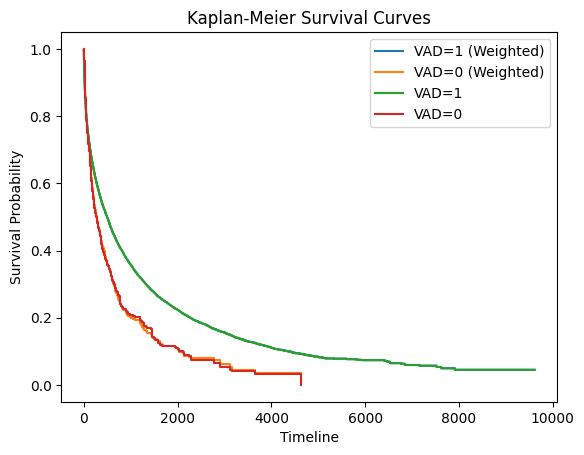

In [34]:
kme_ctrl.plot(label="VAD=1 (Weighted)", ci=False)
kme_trt.plot(label="VAD=0 (Weighted)", ci=False)

akme_ctrl.plot(label="VAD=1", ci=False)
akme_trt.plot(label="VAD=0", ci=False)

plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curves")
plt.legend()

### Task 2.1.4 [2 pts]. 
Propose a propensity-weighted version of the Long-Rank test. Apply this test to check whether the survival outcomes of patients on VAD support differ from those of patients without VAD. Compare the result of this test with the unadjusted test you implemented in Task 2.1.1. Comment on the results.

In [35]:

z, pval = adjusted_logrank_test(duration_ctrl, duration_trt, event_ctrl, event_trt, weights_ctrl, weights_trt)
print(f"Z-statistic: {z}")
print(f"P-value: {pval}")

Z-statistic: 5.933636448791616
P-value: 2.9629754205728887e-09


## 2.2 ML-based Estimation of Average Treatment Effects [6 pts]

### 2.2.1 Clinical Background, Dataset, and Setup

In this task, we will use individual patient data from the International Stroke Trial (IST), one of the largest
randomized trials ever conducted in acute stroke [2]. The trial investigated the impact of aspirin and subcutaneous 
heparin on patients with acute ischemic stroke, with treatment randomization within 48 hours of symptom onset. 
The trial findings indicated no effect of both aspirin and heparin on 14-day and 6-month mortality.
The trial protocol and data dictionary have been provided to you.
The original IST data lacks confounding as it was generated through a randomized trial. The instructor introduced 
confounding artificially by filtering patients out of the trial using a random function that depends on the
patient features. The resulting dataset mimics an observational dataset where treatment is assigned through
a mechanism that depends on patient features. You will conduct the following tasks using the artificially
confounded dataset with the goal of recovering the same treatment effects estimated in the randomized trial.

Estimate the average effect of aspirin and heparin on 14-day mortality using the following estimators. Compare your estimates with those of the original trial and provide commentary on the results.

### Task 2.2.1 [1 pts]. 
A standard difference-in-means estimator.


In [114]:
ist_filepath = project_2_data_dir / "IST" / "IST_corrected.txt"
truncated_ist_filepath = project_2_data_dir / "IST" / "IST_observational.csv"

ist = pd.read_csv(
    ist_filepath,
    sep="\t",
    encoding="utf-16",
    low_memory=False,
)
truncated_ist = pd.read_csv(truncated_ist_filepath, index_col=0)
# Drop the "include" column to match the original IST dataset
truncated_ist = truncated_ist.drop(columns=["include"])

In [117]:
def dm_estimator(
    outcomes_ctrl: np.ndarray, outcomes_trt: np.ndarray
) -> float:
    """Calculate the average treatment effect (ATE) using difference
    in means.

    Args:
        outcomes_ctrl (np.ndarray): Outcomes for control group.
        outcomes_trt (np.ndarray): Outcomes for treatment group.

    Returns:
        float: Average treatment effect.
    """
    return outcomes_trt.mean() - outcomes_ctrl.mean()

In [118]:
is_treated_asp = ist["RXASP"] == "Y"
is_treated_hep = ist["RXHEP"] != "N"

outcomes_ctrl_asp = ist[~is_treated_asp]["ID14"].to_numpy()
outcomes_trt_asp = ist[is_treated_asp]["ID14"].to_numpy()

outcomes_ctrl_hep = ist[~is_treated_hep]["ID14"].to_numpy()
outcomes_trt_hep = ist[is_treated_hep]["ID14"].to_numpy()

ate_asp = dm_estimator(outcomes_ctrl_asp, outcomes_trt_asp)
ate_hep = dm_estimator(outcomes_ctrl_hep, outcomes_trt_hep)
print(f"ATE Aspirin: {ate_asp:.4f}")
print(f"ATE Heparin: {ate_hep:.4f}")

ATE Aspirin: -0.0039
ATE Heparin: -0.0030


In [123]:
is_treated_asp = truncated_ist["RXASP"] == "Y"
is_treated_hep = truncated_ist["RXHEP"] != "N"

outcomes_ctrl_asp = truncated_ist[~is_treated_asp]["ID14"].to_numpy()
outcomes_trt_asp = truncated_ist[is_treated_asp]["ID14"].to_numpy()

outcomes_ctrl_hep = truncated_ist[~is_treated_hep]["ID14"].to_numpy()
outcomes_trt_hep = truncated_ist[is_treated_hep]["ID14"].to_numpy()

ate_asp = dm_estimator(outcomes_ctrl_asp, outcomes_trt_asp)
ate_hep = dm_estimator(outcomes_ctrl_hep, outcomes_trt_hep)
print(f"ATE Aspirin: {ate_asp:.4f}")
print(f"ATE Heparin: {ate_hep:.4f}")

ATE Aspirin: -0.0333
ATE Heparin: -0.0072


### Task 2.2.2 [1 pts]. 
An inverse propensity weighting (IPW) estimator using a Gradient Boosting model for the propensity scores.

In [124]:
confounders = [
    "AGE",
    "SEX",
    "RCONSC",
    "RATRIAL",
    "RSBP",
]
X_truncated_ist = truncated_ist[confounders]

# Impute missing values before encoding categorical variables
numerical_cols = X_truncated_ist.select_dtypes(include=np.number).columns
categorical_cols = X_truncated_ist.select_dtypes(include="object").columns
X_truncated_ist[numerical_cols] = X_truncated_ist[numerical_cols].fillna(
    X_truncated_ist[numerical_cols].mean()
)
X_truncated_ist[categorical_cols] = X_truncated_ist[categorical_cols].fillna(
    X_truncated_ist[categorical_cols].mode().iloc[0]
)
X_truncated_ist = pd.get_dummies(X_truncated_ist, drop_first=True)
X_truncated_ist = X_truncated_ist.to_numpy().astype(np.float32)

/tmp/ipykernel_1099814/1544400898.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_truncated_ist[numerical_cols] = X_truncated_ist[numerical_cols].fillna(
/tmp/ipykernel_1099814/1544400898.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_truncated_ist[categorical_cols] = X_truncated_ist[categorical_cols].fillna(


In [ ]:
y_asp = (truncated_ist["RXASP"] == "Y").to_numpy().astype(np.float32)

gb_asp = GradientBoostingClassifier()
gb_asp.fit(X_truncated_ist, y_asp)
propensity_asp = gb_asp.predict_proba(X_truncated_ist)[:, 1]


def ipw_estimator(
    outcomes: np.array,
    treatment: np.array,
    propensity_scores: np.array,
):
    """Estimate the average treatment effect using inverse probability
    weighting.

    Args:
        outcomes (np.array): Observed outcomes.
        treatment (np.array): Treatment indicators.
        propensity_scores (np.array): Propensity scores.

    Returns:
        float: Average treatment effect.
    """
    return np.mean(
        outcomes * treatment / propensity_scores
        - (1 - treatment) * outcomes / (1 - propensity_scores)
    )


ate_asp_ipw = ipw_estimator(
    truncated_ist["ID14"].to_numpy(),
    y_asp,
    propensity_asp,
)

print(f"ATE Aspirin (IPW): {ate_asp_ipw:.4f}")


y_hep = (truncated_ist["RXHEP"] != "N").to_numpy().astype(np.float32)
gb_hep = GradientBoostingClassifier()
gb_hep.fit(X_truncated_ist, y_hep)
propensity_hep = gb_hep.predict_proba(X_truncated_ist)[:, 1]


ate_hep_ipw = ipw_estimator(
    truncated_ist["ID14"].to_numpy(),
    (truncated_ist["RXHEP"] != "N").to_numpy().astype(np.float32),
    propensity_hep,
)

print(f"ATE Heparin (IPW): {ate_hep_ipw:.4f}")

ATE Aspirin (IPW): -0.0076
ATE Heparin (IPW): -0.0049


### Task 2.2.3 [2 pts]. 
A covariate adjustment estimator using a Gradient Boosting model with T-learner, S-learner, and X-learner architectures.

In [141]:
class TLearner:
    """Implements the T-Learner meta-algorithm for estimating the Average Treatment Effect (ATE).

    The T-Learner uses separate models for the treated and control groups to predict the outcome.
    """

    def __init__(
        self,
        base_model_treated=GradientBoostingRegressor(),
        base_model_control=GradientBoostingRegressor(),
    ):
        """Initializes the T-Learner with base models for treated and control groups.

        Args:
            base_model_treated (object, optional): Model for the treated group. Defaults to GradientBoostingRegressor().
            base_model_control (object, optional): Model for the control group. Defaults to GradientBoostingRegressor().
        """
        self.model_treated = base_model_treated
        self.model_control = base_model_control

    def fit(self, X, T, y):
        """Fits the T-Learner models to the data.

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix.
            T (pd.Series or np.array): Treatment indicator.
            y (pd.Series or np.array): Outcome variable.
        """
        X_treated = X[T == 1]
        y_treated = y[T == 1]
        X_control = X[T == 0]
        y_control = y[T == 0]

        self.model_treated.fit(X_treated, y_treated)
        self.model_control.fit(X_control, y_control)

    def predict(self, X):
        """Predicts the individual treatment effects.

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix for prediction.

        Returns:
            np.array: Individual treatment effect predictions.
        """
        y_pred_treated = self.model_treated.predict(X)
        y_pred_control = self.model_control.predict(X)

        treatment_effects = y_pred_treated - y_pred_control
        return treatment_effects

    def compute_average_treatment_effect(self, X):
        """Computes the Average Treatment Effect (ATE).

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix for prediction.

        Returns:
            float: The estimated ATE.
        """
        treatment_effects = self.predict(X)
        ate = np.mean(treatment_effects)
        return ate


class SLearner:
    """Implements the S-Learner meta-algorithm for estimating the Average Treatment Effect (ATE).

    The S-Learner uses a single model that includes the treatment indicator as a feature to predict the outcome.
    """

    def __init__(self, base_model=GradientBoostingRegressor()):
        """Initializes the S-Learner with a base model.

        Args:
            base_model (object, optional): The base model to use for prediction. Defaults to GradientBoostingRegressor().
        """
        self.model = base_model

    def fit(self, X, T, y):
        """Fits the S-Learner model to the data.

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix.
            T (pd.Series or np.array): Treatment indicator.
            y (pd.Series or np.array): Outcome variable.
        """
        X_s = np.concatenate([X, T.reshape(-1, 1)], axis=1)

        self.model.fit(X_s, y)

    def predict_outcome_value(self, X: np.ndarray, treatment: bool = True) -> np.ndarray:
        t = np.ones((X.shape[0], 1)) if treatment else np.zeros((X.shape[0], 1))
        X_s = np.concatenate([X, t], axis=1)
        return self.model.predict(X_s)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predicts the individual treatment effects.

        Args:
            X (np.ndarray): Feature matrix for prediction.

        Returns:
            np.array: Individual treatment effect predictions.
        """
        y_pred_1 = self.predict_outcome_value(X, treatment=True)
        y_pred_0 = self.predict_outcome_value(X, treatment=False)

        treatment_effects = y_pred_1 - y_pred_0
        return treatment_effects

    def compute_average_treatment_effect(self, X=None):
        """Computes the Average Treatment Effect (ATE).

        Args:
            X (pd.DataFrame or np.ndarray, optional): Feature matrix for prediction. If None, uses the training data.

        Returns:
            float: The estimated ATE.
        """
        treatment_effects = self.predict(X)
        ate = np.mean(treatment_effects)
        return ate


class XLearner:
    """Implements the X-Learner meta-algorithm for estimating the Average Treatment Effect (ATE).

    The X-Learner uses a two-stage approach with imputed treatment effects and optional propensity score weighting.
    """

    def __init__(
        self,
        base_model_outcome_treated=GradientBoostingRegressor(),
        base_model_outcome_control=GradientBoostingRegressor(),
        base_model_effect_treated=GradientBoostingRegressor(),
        base_model_effect_control=GradientBoostingRegressor(),
    ):
        """Initializes the X-Learner with base models for outcomes and treatment effects.

        Args:
            base_model_outcome_treated (object, optional): Model for outcome in treated group. Defaults to GradientBoostingRegressor().
            base_model_outcome_control (object, optional): Model for outcome in control group. Defaults to GradientBoostingRegressor().
            base_model_effect_treated (object, optional): Model for treatment effect in treated group. Defaults to GradientBoostingRegressor().
            base_model_effect_control (object, optional): Model for treatment effect in control group. Defaults to GradientBoostingRegressor().
        """
        self.model_outcome_treated = base_model_outcome_treated
        self.model_outcome_control = base_model_outcome_control
        self.model_effect_treated = base_model_effect_treated
        self.model_effect_control = base_model_effect_control

    def fit(self, X, T, y):
        """Fits the X-Learner models to the data.

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix with shape (n_samples, n_features).
            T (pd.Series or np.ndarray): Treatment indicator (1 for treated, 0 for control) with length n_samples.
            y (pd.Series or np.ndarray): Outcome variable with length n_samples.

        Raises:
            ValueError: If input shapes or lengths are inconsistent (e.g., X, T, y, or optional arguments mismatch).
        """
        # Convert inputs to numpy arrays for consistency
        X = np.asarray(X)
        T = np.asarray(T)
        y = np.asarray(y)

        # Validate input shapes
        if X.shape[0] != len(T) or X.shape[0] != len(y):
            raise ValueError(
                "The number of samples in X, T, and y must match."
            )

        # Split data into treated and control groups
        X_treated = X[T == 1]
        y_treated = y[T == 1]
        X_control = X[T == 0]
        y_control = y[T == 0]

        # Fit outcome models for treated and control groups
        self.model_outcome_treated.fit(X_treated, y_treated)
        self.model_outcome_control.fit(X_control, y_control)

        # Compute imputed treatment effects
        D_treated = y_treated - self.model_outcome_control.predict(X_treated)
        D_control = self.model_outcome_treated.predict(X_control) - y_control

        self.model_effect_treated.fit(X_treated, D_treated)
        self.model_effect_control.fit(X_control, D_control)

    def predict(self, X, propensity_scores=None):
        """Predicts the individual treatment effects.

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix for prediction.
            propensity_scores (pd.Series or np.array, optional): Propensity scores for weighting. If provided, must have the same length as X. If None, uses scores from fit or defaults to 0.5.

        Returns:
            np.array: Individual treatment effect predictions.

        Raises:
            ValueError: If the length of propensity_scores does not match the number of rows in X.
        """
        # Predict treatment effects for treated and control groups
        tau_treated = self.model_effect_treated.predict(X)
        tau_control = self.model_effect_control.predict(X)

        # Determine propensity scores
        if propensity_scores is not None:
            g_x = propensity_scores
        else:
            g_x = 0.5 * np.ones(X.shape[0])

        # Validate propensity scores length
        if len(g_x) != X.shape[0]:
            raise ValueError(
                "Length of propensity_scores must match number of rows in X"
            )

        # Combine predictions using propensity weighting
        treatment_effects = g_x * tau_control + (1 - g_x) * tau_treated
        return treatment_effects

    def compute_average_treatment_effect(self, X, propensity_scores=None):
        """Computes the Average Treatment Effect (ATE).

        Args:
            X (pd.DataFrame or np.ndarray): Feature matrix for prediction.
            propensity_scores (pd.Series or np.array, optional): Propensity scores for weighting. If provided, must have the same length as X. If None, uses scores from fit or defaults to 0.5.

        Returns:
            float: The estimated ATE.
        """
        treatment_effects = self.predict(X, propensity_scores)
        ate = np.mean(treatment_effects)
        return ate

In [142]:
y = truncated_ist["ID14"].to_numpy()

t_learner_asp = TLearner()
t_learner_asp.fit(X_truncated_ist, y_asp, y)
ate_asp_t = t_learner_asp.compute_average_treatment_effect(X_truncated_ist)

s_learner_asp = SLearner()
s_learner_asp.fit(X_truncated_ist, y_asp, y)
ate_asp_s = s_learner_asp.compute_average_treatment_effect(X_truncated_ist)


x_learner_asp = XLearner()
x_learner_asp.fit(X_truncated_ist, y_asp, y)
ate_asp_x = x_learner_asp.compute_average_treatment_effect(
    X_truncated_ist,
    propensity_scores=propensity_asp,
)

print(f"ATE Aspirin (T-Learner): {ate_asp_t:.4f}")
print(f"ATE Aspirin (S-Learner): {ate_asp_s:.4f}")
print(f"ATE Aspirin (X-Learner): {ate_asp_x:.4f}")

ATE Aspirin (T-Learner): 0.0011
ATE Aspirin (S-Learner): 0.0025
ATE Aspirin (X-Learner): 0.0017


In [143]:
t_learner_hep = TLearner()
t_learner_hep.fit(X_truncated_ist, y_hep, y)
ate_hep_t = t_learner_hep.compute_average_treatment_effect(X_truncated_ist)

s_learner_hep = SLearner()
s_learner_hep.fit(X_truncated_ist, y_hep, y)
ate_hep_s = s_learner_hep.compute_average_treatment_effect(X_truncated_ist)

x_learner_hep = XLearner()
x_learner_hep.fit(X_truncated_ist, y_hep, y)
ate_hep_x = x_learner_hep.compute_average_treatment_effect(
    X_truncated_ist,
    propensity_scores=propensity_hep,
)

print(f"ATE Heparin (T-Learner): {ate_hep_t:.4f}")
print(f"ATE Heparin (S-Learner): {ate_hep_s:.4f}")
print(f"ATE Heparin (X-Learner): {ate_hep_x:.4f}")

ATE Heparin (T-Learner): -0.0058
ATE Heparin (S-Learner): -0.0018
ATE Heparin (X-Learner): -0.0067


### Task 2.2.4 [2 pts]. 
An augmented IPW (doubly-robust) estimator that combines the propensity model from
Task 2.2.2 and an outcomes model based on the S-learner in Task 2.2.3

In [ ]:
mu1_asp = s_learner_asp.predict_outcome_value(X_truncated_ist, treatment=True)
mu0_asp = s_learner_asp.predict_outcome_value(X_truncated_ist, treatment=False)
dr_term1 = mu1_asp - mu0_asp
dr_term2 = (y_asp * (y - mu1_asp)) / propensity_asp
dr_term3 = ((1 - y_asp) * (y - mu0_asp)) / (1 - propensity_asp)
ate_asp_dr = np.mean(dr_term1 + dr_term2 - dr_term3)
print(f"ATE Aspirin (Doubly-Robust): {ate_asp_dr:.4f}")

mu1_hep = s_learner_hep.predict_outcome_value(X_truncated_ist, treatment=True)
mu0_hep = s_learner_hep.predict_outcome_value(X_truncated_ist, treatment=False)
dr_term1_hep = mu1_hep - mu0_hep
dr_term2_hep = (y_hep * (y - mu1_hep)) / propensity_hep
dr_term3_hep = ((1 - y_hep) * (y - mu0_hep)) / (1 - propensity_hep)
ate_hep_dr = np.mean(dr_term1_hep + dr_term2_hep - dr_term3_hep)
print(f"ATE Heparin (Doubly-Robust): {ate_hep_dr:.4f}")

ATE Aspirin (Doubly-Robust): 0.0011
ATE Heparin (Doubly-Robust): -0.0046


## 2.3 Counterfactual Inference and Domain Adaptation [8 pts]

In this task, we will explore the application of concepts from the machine learning literature to 
estimate heterogeneous treatment effects. The seminal work in [3] establishes a link between estimating treatment effects
and the domain adaptation problem in machine learning. Using this insight, the authors repurpose ideas from
domain adaptation literature to create a new deep learning model for estimating the conditional average treatment 
effects (CATE) function. The core idea of their algorithm is to eliminate confounding bias by learning a
representation Φ of the features X that aligns the distribution of treated and control populations, Φ(X|T = 1)
and Φ(X|T = 0), in the representation space, referred to by the authors as a “balancing” representation

Please read the paper carefully and complete the following tasks.

### Task 2.3.1 [3 pts]. 

Implement the TARNet and CFR<sub>MMD</sub> models proposed in [3] in PyTorch. Evaluate
the performance of all models using the semisynthetic benchmark dataset included in the Project 2 notebook.

In [210]:
ihdp_filepath = project_2_data_dir / "IHDP" / "ihdp_project2.csv"
ihdp = pd.read_csv(ihdp_filepath, index_col=0)

In [528]:
class IHDPDataset(torch.utils.data.Dataset):
    num_features = 25
    features = [f"X{i}" for i in range(1, num_features + 1)]
    outcome = "Y"
    cf_outcome = "Y_cf"
    treatment = "T"

    train_size = 0.63
    val_size = 0.27
    test_size = 0.1
    val_ratio = val_size / (val_size + train_size)

    def __init__(self, dataframe: pd.DataFrame, split: str = "train") -> None:
        if split == "all":

            dataframe = dataframe.astype(np.float32)
            dataframe = dataframe.reset_index(drop=True)
        else:
            train, test = sklearn.model_selection.train_test_split(
                dataframe,
                test_size=self.test_size,
                random_state=42,
                stratify=dataframe[self.treatment],
            )

            train, val = sklearn.model_selection.train_test_split(
                train,
                test_size=self.val_ratio,
                random_state=42,
                stratify=train[self.treatment],
            )
            split_to_dataframe = {
                "train": train,
                "val": val,
                "test": test,
            }
            dataframe = split_to_dataframe[split].astype(np.float32)
            dataframe = dataframe.reset_index(drop=True)

        self.X = dataframe[self.features].to_numpy()
        self.t = dataframe[self.treatment].to_numpy()[..., np.newaxis]
        self.y = dataframe[self.outcome].to_numpy()[..., np.newaxis]
        self.y_cf = dataframe[self.cf_outcome].to_numpy()[..., np.newaxis]

        self.u = dataframe[self.treatment].to_numpy().mean()

        self.ate = self.compute_ite(self.y, self.t, self.y_cf).mean()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx) -> Dict[str, np.ndarray]:
        sample = {
            "X": self.X[idx],
            "t": self.t[idx],
            "y": self.y[idx],
            "y_cf": self.y_cf[idx],
            "u": self.u,
            "ite": self.compute_ite(self.y[idx], self.t[idx], self.y_cf[idx]),
        }
        return sample

    def compute_ite(
        self, y: np.ndarray, t: np.ndarray, y_cf: np.ndarray
    ) -> np.ndarray:
        y1 = np.where(t == 1, y, y_cf)
        y0 = np.where(t == 0, y, y_cf)
        return y1 - y0

In [570]:
train_ds = IHDPDataset(ihdp)
val_ds = IHDPDataset(ihdp, split="val")
test_ds = IHDPDataset(ihdp, split="test")

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [577]:
class CFRNet(L.LightningModule):
    def __init__(
        self,
        input_dim: int = 25,
        rep_dim: int = 128,
        hidden_dim: int = 64,
        alpha: float = 1,
        lambda_reg: float = 1e-3,
        learning_rate: float = 1e-4,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()

        # Representation network (Phi)
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, rep_dim),
            nn.ReLU(),
            nn.BatchNorm1d(rep_dim),
        )
        # Treated outcome network (h1)
        self.h1 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
        )
        # Control outcome network (h0)
        self.h0 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
        )

    def forward(
        self, x: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of the CFR model.

        Args:
            x (torch.Tensor): Input covariates of shape [batch_size, input_dim]
            t (torch.Tensor): Treatment assignments of shape [batch_size, 1], binary (0 or 1)

        Returns:
            y_pred (torch.Tensor): Predicted outcomes of shape [batch_size, 1]
            r (torch.Tensor): Representations of shape [batch_size, rep_dim]
        """
        r = self.phi(x)
        # Selects h1 or h0 based on t
        y_pred = t * self.h1(r) + (1 - t) * self.h0(r)
        return y_pred, r


    def configure_optimizers(self) -> torch.optim.Optimizer:
        params = [
            {
                "params": self.phi.parameters(),
                "weight_decay": 0.0,
            },  # No weight decay for Phi
            {
                "params": self.h1.parameters(),
                "weight_decay": 2 * self.hparams.lambda_reg,
            },
            {
                "params": self.h0.parameters(),
                "weight_decay": 2 * self.hparams.lambda_reg,
            },
        ]
        optimizer = torch.optim.Adam(
            params,
            lr=self.hparams.learning_rate,
        )
        return optimizer

    def training_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        x = batch["X"]
        t = batch["t"]
        y = batch["y"]
        u = batch["u"]

        y_pred, r = self(x, t)
        factual_loss = self.weighted_mse_loss(y_pred, y, t, u)
        ipm_loss = self.hparams.alpha * self.linear_mmd(r, t)
        loss = factual_loss + ipm_loss

        self.log(
            "train_factual",
            factual_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "train_ipm",
            ipm_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "train_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
        )
        if "ite" in batch:
            ite = batch["ite"]
            ite_hat = self.predict_ite(x)
            sqrt_pehe = self.compute_sqrt_pehe(ite, ite_hat)

            self.log(
                "train_sqrt_pehe",
                sqrt_pehe,
                on_step=True,
                on_epoch=True,
                prog_bar=True,
            )

        return loss

    def validation_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        x = batch["X"]
        t = batch["t"]
        y = batch["y"]

        u = batch["u"]

        y_pred, r = self(x, t)
        factual_loss = self.weighted_mse_loss(y_pred, y, t, u)
        ipm_loss = self.hparams.alpha * self.linear_mmd(r, t)
        loss = factual_loss + ipm_loss

        self.log(
            "val_factual",
            factual_loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "val_ipm",
            ipm_loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "val_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

        if "ite" in batch:
            ite = batch["ite"]
            ite_hat = self.predict_ite(x)
            sqrt_pehe = self.compute_sqrt_pehe(ite, ite_hat)

            self.log(
                "val_sqrt_pehe",
                sqrt_pehe,
                on_step=False,
                on_epoch=True,
                prog_bar=True,
            )

        return loss

    def test_step(
        self, batch: Dict[str, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        x = batch["X"]
        t = batch["t"]
        y = batch["y"]
        u = batch["u"]

        y_pred, r = self(x, t)
        factual_loss = self.weighted_mse_loss(y_pred, y, t, u)
        ipm_loss = self.hparams.alpha * self.linear_mmd(r, t)
        loss = factual_loss + ipm_loss

        self.log(
            "test_factual",
            factual_loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_ipm",
            ipm_loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        if "ite" in batch:
            ite = batch["ite"]
            ite_hat = self.predict_ite(x)
            sqrt_pehe = self.compute_sqrt_pehe(ite, ite_hat)

            self.log(
                "test_sqrt_pehe",
                sqrt_pehe,
                on_step=True,
                on_epoch=True,
                prog_bar=True,
            )
        return loss

    def weighted_mse_loss(
        self,
        y_pred: torch.Tensor,
        y: torch.Tensor,
        t: torch.Tensor,
        u: float,
    ) -> torch.Tensor:
        """Compute the weighted mean squared error loss.

        Args:
            y_pred (torch.Tensor): Predicted outcomes [batch_size, 1]
            y (torch.Tensor): Observed outcomes [batch_size, 1]
            t (torch.Tensor): Treatment assignments [batch_size, 1]
            u (float): Proportion of treated units in the dataset

        Returns:
            torch.Tensor: Weighted MSE loss
        """
        weights = t / (2 * u) + (1 - t) / (2 * (1 - u))
        loss = (y_pred - y) ** 2
        weighted_loss = weights * loss

        return weighted_loss.mean()

    def linear_mmd(self, r: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """Compute the squared linear MMD between treated and control representations.

        Args:
            r (torch.Tensor): Representations [batch_size, rep_dim]
            t (torch.Tensor): Treatment assignments [batch_size, 1]

        Returns:
            torch.Tensor: Linear MMD value
        """
        r_treated = r[t.squeeze() == 1]
        r_control = r[t.squeeze() == 0]
        # Handle empty groups
        if r_treated.size(0) == 0 or r_control.size(0) == 0:
            return torch.tensor(0.0, device=r.device)
        mean_treated = r_treated.mean(dim=0)
        mean_control = r_control.mean(dim=0)
        mmd = (mean_treated - mean_control).pow(2).sum()
        return mmd

    def predict_ite(self, x: torch.Tensor) -> torch.Tensor:
        """Predict individual treatment effects (ITE).

        Args:
            x (torch.Tensor): Input covariates of shape [batch_size, input_dim]

        Returns:
            torch.Tensor: Predicted ITE of shape [batch_size, 1]
        """
        r = self.phi(x)
        ite = self.h1(r) - self.h0(r)
        return ite

    def compute_ate(self, x: torch.Tensor) -> torch.Tensor:
        """Compute the Average Treatment Effect (ATE).

        Args:
            x (torch.Tensor): Input covariates of shape [batch_size, input_dim]

        Returns:
            torch.Tensor: Estimated ATE
        """
        ite = self.predict_ite(x)
        return ite.mean()

    def compute_sqrt_pehe(
        self,
        predicted_ite: torch.Tensor,
        ite: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the Precision in Estimation of Heterogeneous Effects (PEHE).

        Args:
            predicted_ite (torch.Tensor): Predicted Individual Treatment Effects (ITEs)
            ite (torch.Tensor): True ITEs

        Returns:
            torch.Tensor: PEHE value
        """
        return torch.sqrt(((predicted_ite - ite) ** 2).mean())

In [578]:
trainer = L.Trainer(max_epochs=100, log_every_n_steps=25)
tarnet = CFRNet(alpha=0)
trainer.fit(tarnet, train_loader)
trainer.validate(tarnet, val_loader)
trainer.test(tarnet, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 10.2 K | train
1 | h1   | Sequential | 8.3 K  | train
2 | h0   | Sequential | 8.3 K  | train
--------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 31.94it/s, v_num=95, train_factual_step=0.511, train_ipm_step=0.000, train_loss_step=0.511, train_sqrt_pehe_step=4.220, train_factual_epoch=0.720, train_ipm_epoch=0.000, train_loss_epoch=0.720, train_sqrt_pehe_epoch=4.140]

`Trainer.fit` stopped: `max_epochs=100` reached.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 58.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_factual          1.5672295093536377
         val_ipm                    0.0
        val_loss            1.5672295093536377
      val_sqrt_pehe          4.04496955871582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 40.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────

[{'test_factual': 1.2588926553726196,
  'test_ipm': 0.0,
  'test_loss': 1.2588926553726196,
  'test_sqrt_pehe_epoch': 4.304728984832764}]

In [579]:
trainer = L.Trainer(max_epochs=100, log_every_n_steps=25)
model = CFRNet()
trainer.fit(model, train_loader)
trainer.validate(model, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 10.2 K | train
1 | h1   | Sequential | 8.3 K  | train
2 | h0   | Sequential | 8.3 K  | train
--------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 47.96it/s, v_num=96, train_factual_step=0.810, train_ipm_step=23.80, train_loss_step=24.60, train_sqrt_pehe_step=3.400, train_factual_epoch=0.999, train_ipm_epoch=10.10, train_loss_epoch=11.10, train_sqrt_pehe_epoch=3.700]

`Trainer.fit` stopped: `max_epochs=100` reached.


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 80.85it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       val_factual          1.3742179870605469
         val_ipm            13.303850173950195
        val_loss            14.678067207336426
      val_sqrt_pehe         3.7029778957366943
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 51.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────

[{'test_factual': 1.8427592515945435,
  'test_ipm': 11.91020679473877,
  'test_loss': 13.752965927124023,
  'test_sqrt_pehe_epoch': 4.134998798370361}]

### Task 2.3.2 [1 pts]. 

Visualize the treated and control features before and after applying the balancing representation Φ(.) using t-SNE. Comment on the results.

In [319]:
train_ihdp_X = torch.tensor(train_ds.X)
with torch.no_grad():
    phi = model.phi(train_ihdp_X).numpy()
X_tsne = TSNE(n_components=2).fit_transform(train_ds.X)
phi_tsne = TSNE(n_components=2).fit_transform(phi)

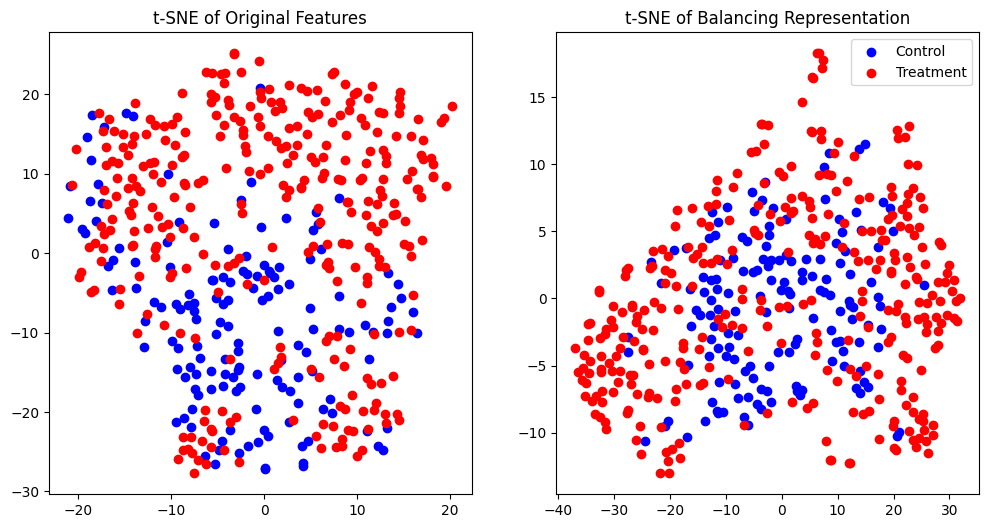

In [320]:
# Assuming X_tsne, phi_tsne are NumPy arrays, and train_ds.t is a NumPy array
# Identify indices for control (0) and treatment (1) groups
control_idx = (train_ds.t == 0).flatten()
treatment_idx = (train_ds.t == 1).flatten()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot t-SNE of original features on the first subplot
ax1.scatter(X_tsne[control_idx, 0], X_tsne[control_idx, 1], color='blue', label='Control')
ax1.scatter(X_tsne[treatment_idx, 0], X_tsne[treatment_idx, 1], color='red', label='Treatment')
ax1.set_title("t-SNE of Original Features")

# Plot t-SNE of representation on the second subplot
ax2.scatter(phi_tsne[control_idx, 0], phi_tsne[control_idx, 1], color='blue', label='Control')
ax2.scatter(phi_tsne[treatment_idx, 0], phi_tsne[treatment_idx, 1], color='red', label='Treatment')
ax2.set_title("t-SNE of Balancing Representation")

# Add a legend to the second subplot
ax2.legend()

# Display the figure
plt.show()

### Task 2.3.3 [1 pts]. 

Show the impact of the scaling parameter α (Eq. (3) in [3]) on the loss function on the
test set for the Maximum Mean Discrepancy (MMD) regularizer.

In [321]:
alphas = [0, 0.1, 0.5, 1, 5, 10]
factual_losses = []
ipm_losses = []
pehes = []
losses = []

for alpha in tqdm(alphas, desc="Training CFRNet with different alpha values"):
    print(f"Training with alpha={alpha}")
    model_alpha = CFRNet(alpha=alpha)
    trainer_alpha = L.Trainer(
        max_epochs=100,
        log_every_n_steps=25,
        logger=False,
        enable_progress_bar=False,
        enable_model_summary=False,
    )
    trainer_alpha.fit(model_alpha, train_loader)
    test_res = trainer_alpha.test(model_alpha, test_loader, verbose=False)[0]
    factual_losses.append(test_res["test_factual"])
    ipm_losses.append(test_res["test_ipm"])
    pehes.append(test_res["test_pehe"])
    losses.append(test_res["test_loss"])

Training CFRNet with different alpha values:   0%|          | 0/6 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/aaron/Projects/cph-200b/Project 2/checkpoints exists and is not empty.
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training with alpha=0


`Trainer.fit` stopped: `max_epochs=100` reached.
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
Training CFRNet with different alpha values:  17%|█▋        | 1/6 [00:12<01:01, 12.39s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with alpha=0.1


`Trainer.fit` stopped: `max_epochs=100` reached.
Training CFRNet with different alpha values:  33%|███▎      | 2/6 [00:23<00:46, 11.69s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with alpha=0.5


`Trainer.fit` stopped: `max_epochs=100` reached.
Training CFRNet with different alpha values:  50%|█████     | 3/6 [00:35<00:35, 11.97s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with alpha=1


`Trainer.fit` stopped: `max_epochs=100` reached.
Training CFRNet with different alpha values:  67%|██████▋   | 4/6 [00:48<00:24, 12.08s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with alpha=5


`Trainer.fit` stopped: `max_epochs=100` reached.
Training CFRNet with different alpha values:  83%|████████▎ | 5/6 [01:01<00:12, 12.51s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with alpha=10


`Trainer.fit` stopped: `max_epochs=100` reached.
Training CFRNet with different alpha values: 100%|██████████| 6/6 [01:17<00:00, 13.00s/it]


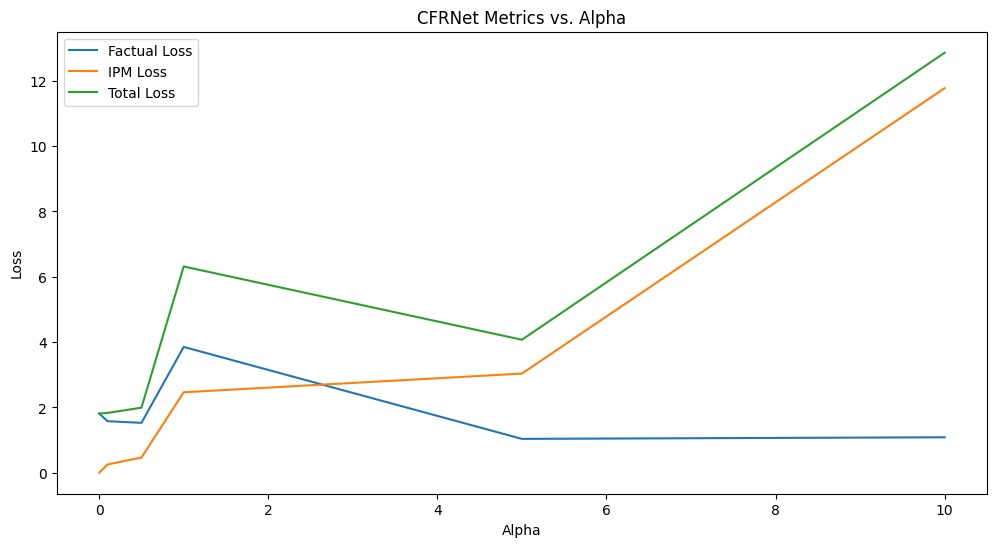

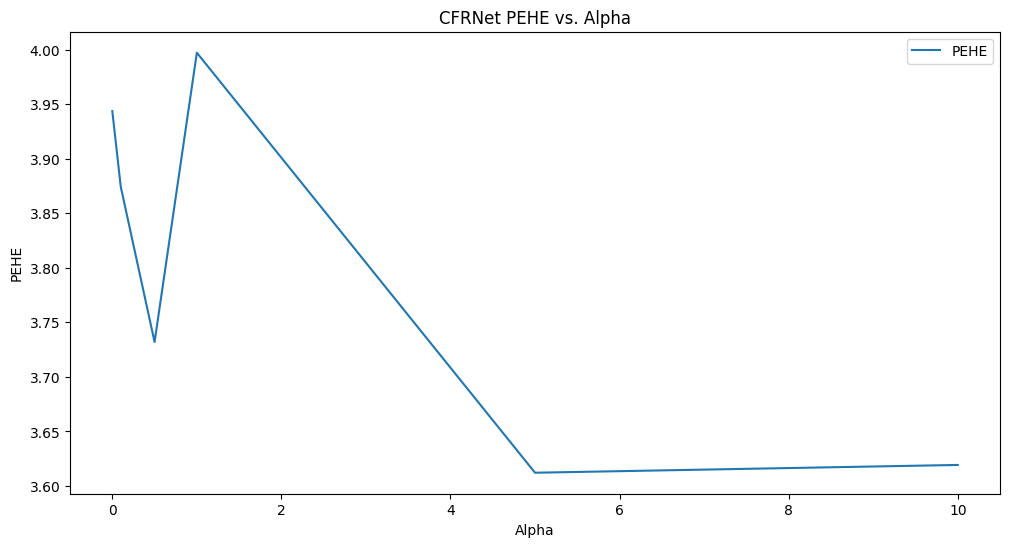

In [323]:
# plot all metrics: factual loss, IPM loss, PEHE, and total loss
plt.figure(figsize=(12, 6))
plt.plot(alphas, factual_losses, label="Factual Loss")
plt.plot(alphas, ipm_losses, label="IPM Loss")
plt.plot(alphas, losses, label="Total Loss")
plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.title("CFRNet Metrics vs. Alpha")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(alphas, pehes, label="PEHE")
plt.xlabel("Alpha")
plt.ylabel("PEHE")
plt.title("CFRNet PEHE vs. Alpha")
plt.legend()
plt.show()

### Task 2.3.4 [3 pts].

Use the TARNet and CFR<sub>MMD</sub> models to estimate average treatment effects using
the IST data in Task 2.2. Assess the alignment of your estimates with the trial results and compare them
to the estimators in Tasks 2.2.3 and 2.2.4.

In [ ]:
from torch.utils.data import TensorDataset

y_truncated_ist = truncated_ist["ID14"].to_numpy()
t_asp = (truncated_ist["RXASP"] == "Y").to_numpy().astype(np.float32)
t_hep = (truncated_ist["RXHEP"] != "N").to_numpy().astype(np.float32)

# Convert the above to tensor
X_truncated_ist = torch.tensor(X_truncated_ist)
y_truncated_ist = torch.tensor(y_truncated_ist)
t_asp = torch.tensor(t_asp)
t_hep = torch.tensor(t_hep)
u_asp = t_asp.mean().unsqueeze(0).repeat(len(t_asp), 1)
u_hep = t_hep.mean().unsqueeze(0).repeat(len(t_hep), 1)

# make datasets and dataloaders for the aspirin and heparin
ds_asp = TensorDataset(X_truncated_ist, y_truncated_ist, t_asp, u_asp)
ds_hep = TensorDataset(X_truncated_ist, y_truncated_ist, t_hep, u_hep)


def collate_fn(batch):
    x = torch.stack([item[0] for item in batch])
    y = torch.stack([item[1] for item in batch])
    t = torch.stack([item[2] for item in batch])
    u = torch.stack([item[3] for item in batch])
    return {"X": x, "y": y, "t": t, "u": u}


loader_asp = torch.utils.data.DataLoader(
    ds_asp,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)
loader_hep = torch.utils.data.DataLoader(
    ds_hep,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

/tmp/ipykernel_1099814/2802357606.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_truncated_ist = torch.tensor(X_truncated_ist)


In [357]:
num_features = X_truncated_ist.shape[1]
tarnet_asp = CFRNet(input_dim=num_features, alpha=0)
tarnet_hep = CFRNet(input_dim=num_features, alpha=0)

trainer_asp = L.Trainer(max_epochs=100, log_every_n_steps=25)
trainer_hep = L.Trainer(max_epochs=100, log_every_n_steps=25)

trainer_asp.fit(tarnet_asp, loader_asp)
trainer_hep.fit(tarnet_hep, loader_hep)

# get ate for aspirin and heparin
ate_asp = tarnet_asp.compute_ate(X_truncated_ist)
ate_hep = tarnet_hep.compute_ate(X_truncated_ist)


print(f"ATE Aspirin (TARNet): {ate_asp:.4f}")
print(f"ATE Heparin (TARNet): {ate_hep:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 9.0 K  | train
1 | h1   | Sequential | 8.3 K  | train
2 | h0   | Sequential | 8.3 K  | train
--------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 52.20it/s, v_num=30, train_factual_step=0.077, train_ipm_step=0.000, train_loss_step=0.077, train_factual_epoch=0.0962, train_ipm_epoch=0.000, train_loss_epoch=0.0962]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 49.55it/s, v_num=30, train_factual_step=0.077, train_ipm_step=0.000, train_loss_step=0.077, train_factual_epoch=0.0962, train_ipm_epoch=0.000, train_loss_epoch=0.0962]



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 9.0 K  | train
1 | h1   | Sequential | 8.3 K  | train
2 | h0   | Sequential | 8.3 K  | train
--------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 45.62it/s, v_num=31, train_factual_step=0.142, train_ipm_step=0.000, train_loss_step=0.142, train_factual_epoch=0.101, train_ipm_epoch=0.000, train_loss_epoch=0.101]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 44.27it/s, v_num=31, train_factual_step=0.142, train_ipm_step=0.000, train_loss_step=0.142, train_factual_epoch=0.101, train_ipm_epoch=0.000, train_loss_epoch=0.101]
ATE Aspirin (TARNet): -0.0285
ATE Heparin (TARNet): -0.0094


In [364]:
cfr_net_asp = CFRNet(num_features, alpha=0.5)
cfr_net_hep = CFRNet(num_features, alpha=0.5)

trainer_asp = L.Trainer(max_epochs=100, log_every_n_steps=25)
trainer_hep = L.Trainer(max_epochs=100, log_every_n_steps=25)

trainer_asp.fit(cfr_net_asp, loader_asp)
trainer_hep.fit(cfr_net_hep, loader_hep)

ate_asp = cfr_net_asp.compute_ate(X_truncated_ist)
ate_hep = cfr_net_hep.compute_ate(X_truncated_ist)

print(f"ATE Aspirin (CFRNet): {ate_asp:.4f}")
print(f"ATE Heparin (CFRNet): {ate_hep:.4f}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 9.0 K  | train
1 | h1   | Sequential | 8.3 K  | train
2 | h0   | Sequential | 8.3 K  | train
--------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connecto

Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 71.50it/s, v_num=39, train_factual_step=0.104, train_ipm_step=0.00976, train_loss_step=0.114, train_factual_epoch=0.096, train_ipm_epoch=0.0234, train_loss_epoch=0.119]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 69.06it/s, v_num=39, train_factual_step=0.104, train_ipm_step=0.00976, train_loss_step=0.114, train_factual_epoch=0.096, train_ipm_epoch=0.0234, train_loss_epoch=0.119]


  | Name | Type       | Params | Mode 
--------------------------------------------
0 | phi  | Sequential | 9.0 K  | train
1 | h1   | Sequential | 8.3 K  | train
2 | h0   | Sequential | 8.3 K  | train
--------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 60.49it/s, v_num=40, train_factual_step=0.102, train_ipm_step=0.0164, train_loss_step=0.118, train_factual_epoch=0.101, train_ipm_epoch=0.0129, train_loss_epoch=0.114]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 19/19 [00:00<00:00, 58.39it/s, v_num=40, train_factual_step=0.102, train_ipm_step=0.0164, train_loss_step=0.118, train_factual_epoch=0.101, train_ipm_epoch=0.0129, train_loss_epoch=0.114]
ATE Aspirin (CFRNet): -0.0312
ATE Heparin (CFRNet): -0.0033


## 2.4 NeurIPS Reviewer for a Day: Reviewing & Reproducing Recent Research on ML-Based Causal Inference [10 pts]
In this task, we will focus on one paper that proposes new methods for estimating CATE inspired by ideas we studied in Lectures 7, 8 and 9. The paper is “Adapting Neural Networks for the Estimation of Treatment
Effects” by Claudia Shi, David Blei and Victor Veitch, which was published in NeurIPS 2019. The objective of this task is to develop critical paper review skills and practice reproducing research results. Please read
the paper carefully and complete the following tasks.

### Task 2.4.1 [5 pts]. 

Please review the NeurIPS 2024 reviewing guidelines and write a comprehensive review of this paper in accordance with those guidelines.



### Task 2.4.2 [5 pts]. 

Implement the DragonNet and Targeted regularization methods proposed in this paper in PyTorch and reproduce their performance results on the IHDP dataset (Table 1 in the paper)

In [515]:
class Dragonnet(L.LightningModule):
    def __init__(
        self,
        input_dim,
        shared_hidden=200,
        outcome_hidden=100,
        alpha: float = 1.0,
        learning_rate: float = 1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()

        # Shared representation layers: 3 layers with 200 units each
        self.shared_net = nn.Sequential(
            nn.Linear(input_dim, shared_hidden),
            nn.ReLU(),
            nn.Linear(shared_hidden, shared_hidden),
            nn.ReLU(),
            nn.Linear(shared_hidden, shared_hidden),
            nn.ReLU(),
        )

        # Propensity score head: linear layer followed by sigmoid
        self.propensity_head = nn.Linear(shared_hidden, 1)

        # Outcome head for T=0: 2 hidden layers with 100 units each
        self.outcome_head_0 = nn.Sequential(
            nn.Linear(shared_hidden, outcome_hidden),
            nn.ReLU(),
            nn.Linear(outcome_hidden, outcome_hidden),
            nn.ReLU(),
            nn.Linear(outcome_hidden, 1),
        )

        # Outcome head for T=1: 2 hidden layers with 100 units each
        self.outcome_head_1 = nn.Sequential(
            nn.Linear(shared_hidden, outcome_hidden),
            nn.ReLU(),
            nn.Linear(outcome_hidden, outcome_hidden),
            nn.ReLU(),
            nn.Linear(outcome_hidden, 1),
        )

    def forward(self, x):
        """
        Forward pass of Dragonnet.

        Args:
            x (torch.Tensor): Covariates tensor of shape (batch_size, input_dim)

        Returns:
            g (torch.Tensor): Propensity score predictions, shape (batch_size, 1)
            q0 (torch.Tensor): Outcome predictions for T=0, shape (batch_size, 1)
            q1 (torch.Tensor): Outcome predictions for T=1, shape (batch_size, 1)
        """
        # Compute shared representation Z(X)
        z = self.shared_net(x)

        # Propensity score prediction
        g = torch.sigmoid(self.propensity_head(z))

        # Outcome predictions
        q0 = self.outcome_head_0(z)
        q1 = self.outcome_head_1(z)

        return g, q0, q1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
        )
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",
                factor=0.5,
                patience=2,
            ),
            "monitor": "train_loss_epoch",
        }

        return [optimizer], [scheduler]

    def predict_ite(self, x: torch.Tensor) -> torch.Tensor:
        """Predict individual treatment effects (ITE).

        Args:
            x (torch.Tensor): Input covariates of shape [batch_size, input_dim]

        Returns:
            torch.Tensor: Predicted ITE of shape [batch_size, 1]
        """
        g, q0, q1 = self(x)
        ite = q1 - q0
        return ite

    def compute_ate(self, x: torch.Tensor) -> torch.Tensor:
        """Compute the Average Treatment Effect (ATE).

        Args:
            x (torch.Tensor): Input covariates of shape [batch_size, input_dim]

        Returns:
            torch.Tensor: Estimated ATE
        """
        ite = self.predict_ite(x)
        return ite.mean()

    def compute_ate_with_error(
        self, x: torch.Tensor, alpha=0.05
    ) -> Tuple[float, float]:
        """Compute the Average Treatment Effect (ATE) with confidence intervals.

        Args:
            x (torch.Tensor): Input covariates of shape [batch_size, input_dim]
            alpha (float): Confidence level

        Returns:
            Tuple[float, float]: Estimated ATE and margin of error
        """
        ite = self.predict_ite(x)
        ate = ite.mean()
        n = len(ite)
        se = ite.std() / np.sqrt(n)
        z = scipy.stats.norm.ppf(1 - alpha / 2)
        margin_of_error = z * se
        return ate, margin_of_error

    def training_step(self, batch, batch_idx):
        x, t, y = batch["X"], batch["t"], batch["y"]
        g, q0, q1 = self(x)

        loss = self.dragonnet_loss(y, t, g, q0, q1, self.hparams.alpha)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, y = batch["X"], batch["t"], batch["y"]
        g, q0, q1 = self(x)

        loss = self.dragonnet_loss(y, t, g, q0, q1, self.hparams.alpha)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def dragonnet_loss(self, y, t, g, q0, q1, alpha=1.0):
        """
        Compute the Dragonnet loss function as per Equation 2.2 in the paper.

        Args:
            y (torch.Tensor): True outcomes, shape (batch_size, 1)
            t (torch.Tensor): Treatment assignments (0 or 1), shape (batch_size, 1)
            g (torch.Tensor): Predicted propensity scores, shape (batch_size, 1)
            q0 (torch.Tensor): Predicted outcomes for T=0, shape (batch_size, 1)
            q1 (torch.Tensor): Predicted outcomes for T=1, shape (batch_size, 1)
            alpha (float): Weight for propensity loss, default 1.0

        Returns:
            torch.Tensor: Total loss
        """
        # Select the predicted outcome based on the actual treatment
        q_pred = t * q1 + (1 - t) * q0  # Q^{nn}(t_i, x_i)

        # Outcome loss: mean squared error
        outcome_loss = F.mse_loss(q_pred, y)

        # Propensity loss: binary cross-entropy
        propensity_loss = F.binary_cross_entropy(g, t)

        # Total loss
        total_loss = outcome_loss + alpha * propensity_loss
        return total_loss

In [ ]:
train_ds = IHDPDataset(ihdp)
val_ds = IHDPDataset(ihdp, split="val")
test_ds = IHDPDataset(ihdp, split="test")
all_ds = IHDPDataset(ihdp, split="all")

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True
)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64)

early_stop_callback = L.pytorch.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=40,
    verbose=False,
    mode="min",
)
trainer = L.Trainer(
    max_epochs=100, log_every_n_steps=15, callbacks=[early_stop_callback]
)

model = Dragonnet(input_dim=25, alpha=1, learning_rate=5e-3)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | shared_net      | Sequential | 85.6 K | train
1 | propensity_head | Linear     | 201    | train
2 | outcome_head_0  | Sequential | 30.3 K | train
3 | outcome_head_1  | Sequential | 30.3 K | train
-------------------------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.586     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/aaron/miniconda3/envs/cph200b-project-2/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=15). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 53: 100%|██████████| 8/8 [00:00<00:00, 53.01it/s, v_num=79, train_loss_step=0.197, val_loss=3.000, train_loss_epoch=0.136] 


In [ ]:
val_ate = val_ds.ate
test_ate = test_ds.ate
all_ate = all_ds.ate

with torch.no_grad():
    predicted_test_ate = model.compute_ate(torch.tensor(test_ds.X)).item()
    predicted_val_ate = model.compute_ate(torch.tensor(val_ds.X)).item()
    predicted_all_ate = model.compute_ate(torch.tensor(all_ds.X)).item()

In [531]:
delta_in = np.abs(predicted_val_ate - val_ate).item()
delta_out = np.abs(predicted_test_ate - test_ate).item()
delta_all = np.abs(predicted_all_ate - all_ate).item()

print(f"Absolute error in ATE (val): {delta_in:.4f}")
print(f"Absolute error in ATE (test): {delta_out:.4f}")
print(f"Absolute error in ATE (all): {delta_all:.4f}")

Absolute error in ATE (val): 0.1047
Absolute error in ATE (test): 0.1580
Absolute error in ATE (all): 0.0393


In [567]:
early_stop_callback = L.pytorch.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=40,
    verbose=False,
    mode="min",
)
trainer = L.Trainer(
    max_epochs=100, log_every_n_steps=15, callbacks=[early_stop_callback]
)

model_no_reg = Dragonnet(input_dim=25, alpha=1, learning_rate=5e-3)
trainer.fit(model_no_reg, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | shared_net      | Sequential | 85.6 K | train
1 | propensity_head | Linear     | 201    | train
2 | outcome_head_0  | Sequential | 30.3 K | train
3 | outcome_head_1  | Sequential | 30.3 K | train
-------------------------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.586     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 52: 100%|██████████| 8/8 [00:00<00:00, 61.20it/s, v_num=91, train_loss_step=0.0812, val_loss=2.360, train_loss_epoch=0.0717]


In [568]:
with torch.no_grad():
    predicted_test_ate_ng = model_no_reg.compute_ate(torch.tensor(test_ds.X)).item()
    predicted_val_ate_ng = model_no_reg.compute_ate(torch.tensor(val_ds.X)).item()
    predicted_all_ate_ng = model_no_reg.compute_ate(torch.tensor(all_ds.X)).item()

In [569]:
delta_in_ng = np.abs(predicted_val_ate_ng - val_ate).item()
delta_out_ng = np.abs(predicted_test_ate_ng - test_ate).item()
delta_all_ng = np.abs(predicted_all_ate_ng - all_ate).item()

print(f"Absolute error in ATE (val): {delta_in_ng:.4f}")
print(f"Absolute error in ATE (test): {delta_out_ng:.4f}")
print(f"Absolute error in ATE (all): {delta_all_ng:.4f}")

Absolute error in ATE (val): 0.1494
Absolute error in ATE (test): 0.2409
Absolute error in ATE (all): 0.1410
